In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot
import folium
import webbrowser
from folium import plugins
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score,log_loss,classification_report,confusion_matrix,jaccard_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import itertools

In [2]:
seattle_df=pd.read_csv('C:\\DataScience\\IBM\\Capstone_Project\\Data-Collisions.csv')
seattle_df.dtypes
severity_code = seattle_df['SEVERITYCODE'].values
labels = preprocessing.LabelEncoder()
labels.fit([1, 2])
severity_code = labels.transform (severity_code)
seattle_df["SEVERITYCODE"] = severity_code
seattle_df.head()

C:\Users\NB57716\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,1,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,0,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,0,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,0,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,1,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


C:\Users\NB57716\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


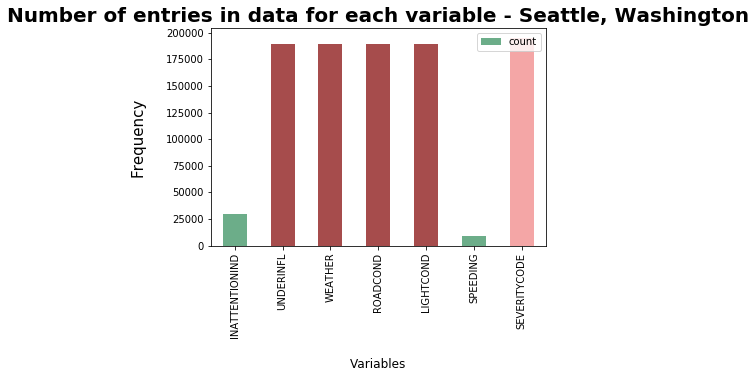

In [3]:
#Descriptive Stats
descriptive_stats= seattle_df.describe(include="all")

    #Plotting counts of selected variables
descriptive_stats_plot=descriptive_stats[["INATTENTIONIND","UNDERINFL","WEATHER","ROADCOND","LIGHTCOND","SPEEDING","SEVERITYCODE"]]
descriptive_stats_plot.drop(['unique','top','freq','mean','std','min','max','25%','50%','75%'],axis=0,inplace=True)
descriptive_stats_plot=descriptive_stats_plot.transpose()

color_yo=['seagreen','maroon','maroon','maroon','maroon','seagreen','lightcoral']
descriptive_stats_plot.plot(kind='bar',alpha=0.70,color=[color_yo])
plt.rcParams["figure.figsize"] = [16,9]
plt.title('Number of entries in data for each variable - Seattle, Washington', fontsize=20, fontweight='bold')
plt.xlabel("Variables",fontsize=12,labelpad=20)
plt.ylabel("Frequency",fontsize=15,labelpad=20)
plt.xticks(rotation=90)
plt.show()

In [4]:
#Check IncKey unqiue numbers
seattle_df['INCKEY'].nunique()

seattle_df.INATTENTIONIND.replace(['Y', np.nan], [1, 0], inplace=True)
seattle_df.UNDERINFL.replace(['N', 'Y'], [0, 1], inplace=True)
seattle_df.SPEEDING.replace(['Y', np.nan], [1, 0], inplace=True)

seattle_df.LIGHTCOND.replace(['Daylight', 'Dark - Street Lights On', 'Dark - No Street Lights', 
                              'Dark - Street Lights Off', 'Dark - Unknown Lighting', 'Dusk', 'Dawn', 'Other'], [0, 1, 2, 2, 2, 1, 1, 'Unknown'], inplace=True)

seattle_df.WEATHER.replace(['Clear', 'Raining', 'Overcast', 'Snowing', 'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt', 'Severe Crosswind', 'Partly Cloudy', 'Other'], 
                           [0, 3, 1, 3, 2, 3, 2, 2, 1, 'Unknown'], inplace=True)
 
seattle_df.ROADCOND.replace(['Dry', 'Wet', 'Ice', 'Snow/Slush', 'Standing Water', 'Sand/Mud/Dirt', 'Oil', 'Other'], 
                           [0, 2, 2, 1, 2, 1, 2, 'Unknown'], inplace=True)


In [5]:
#Making new dataframe with only variables and unique keys
selected=seattle_df[["INCKEY","INATTENTIONIND","UNDERINFL","WEATHER","ROADCOND","LIGHTCOND","SPEEDING","SEVERITYCODE"]]
selected_df=selected.copy()
selected_df.dropna(axis=0,how='any',inplace=True)
feature_stats=selected_df.describe()

np.count_nonzero(selected_df['UNDERINFL'])

89474

In [6]:
lightcond = selected_df[selected_df ['LIGHTCOND'] == 'Unknown'].values
lightcond[0:9036]=0
lightcond[9036:13417]=1
lightcond[13417:13961]=2
selected_df[selected_df.LIGHTCOND == "Unknown"] = lightcond

In [7]:
roadcond = selected_df[selected_df ['ROADCOND'] == 'Unknown'].values
roadcond[0:9954]=0
roadcond[9954:10040]=1
roadcond[10040:15163]=2
selected_df[selected_df.ROADCOND == "Unknown"] = roadcond

In [8]:
weather = selected_df[selected_df ['WEATHER'] == 'Unknown'].values
weather[0:10151]=0
weather[10151:12683]=1
weather[12683:12742]=2
weather[12742:15864]=3
selected_df[selected_df.WEATHER == "Unknown"] = weather

In [9]:
selected_df["LIGHTCOND"]=selected_df["LIGHTCOND"].astype(int)
selected_df["ROADCOND"]=selected_df["ROADCOND"].astype(int)
selected_df["WEATHER"]=selected_df["WEATHER"].astype(int)
selected_df["SPEEDING"]=selected_df["SPEEDING"].astype(int)
selected_df["INATTENTIONIND"]=selected_df["INATTENTIONIND"].astype(int)
selected_df["UNDERINFL"]=selected_df["UNDERINFL"].astype(int)

In [10]:
X=selected_df[["SPEEDING","INATTENTIONIND","UNDERINFL","ROADCOND","WEATHER","LIGHTCOND"]].values
y=selected_df[["SEVERITYCODE"]].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (132535, 6) (132535, 1)
Test set: (56802, 6) (56802, 1)


In [12]:
from imblearn.over_sampling import SMOTE
s = SMOTE (random_state=0)
smote_data_X, smote_data_y= s.fit_sample(X_train, y_train)

In [13]:
#Make reduced df from feature_df to get a few random points to make map
limit = 100005
reduced_df = selected_df.iloc [0:limit:5, 0:]
#Folium Map
seattle_map = folium.Map(location=[47.61536892, -122.3302243], zoom_start=10)

In [1]:
# instantiate a mark cluster object for the incidents in the dataframe
#incidents = plugins.MarkerCluster().add_to(seattle_map)

# loop through the dataframe and add each data point to the mark cluster#
#for lat, lng, label, in zip(reduced_df.Y, reduced_df.X, reduced_df.SEVERITYCODE):
#    folium.Marker(
 #   location=[lat, lng],
  #  icon=None,
   # popup=label,
  #  ).add_to(incidents)

#seattle_map.add_child(incidents)

In [18]:
# display map
seattle_map
seattle_map.save("seattlemap.html")
webbrowser.open("seattlemap.html")

True

In [14]:
def cm_plot(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
#Building KNN Model
from sklearn.neighbors import KNeighborsClassifier
k=25

neighbor=KNeighborsClassifier(n_neighbors = k).fit(smote_data_X, smote_data_y)
neighbor

yhat=neighbor.predict(X_test)
yhat[0:5]

print('Accuracy score for KNN Model = ', accuracy_score(yhat, y_test))

print(pd.crosstab(y_test.ravel(), yhat.ravel(), rownames = ['True'], colnames = ['Predicted'], margins = True))

print(classification_report(yhat,y_test))

f1_score(y_test, yhat, average='macro')

Accuracy score for KNN Model =  0.6661913312911517
Predicted      0     1   2    All
True                             
0          33813  4833   0  38646
1          14128  3937   0  18065
2              0     0  91     91
All        47941  8770  91  56802
              precision    recall  f1-score   support

           0       0.87      0.71      0.78     47941
           1       0.22      0.45      0.29      8770
           2       1.00      1.00      1.00        91

    accuracy                           0.67     56802
   macro avg       0.70      0.72      0.69     56802
weighted avg       0.77      0.67      0.71     56802



0.6914802348299863

Confusion matrix, without normalization
[[ 3937 14128]
 [ 4833 33813]]


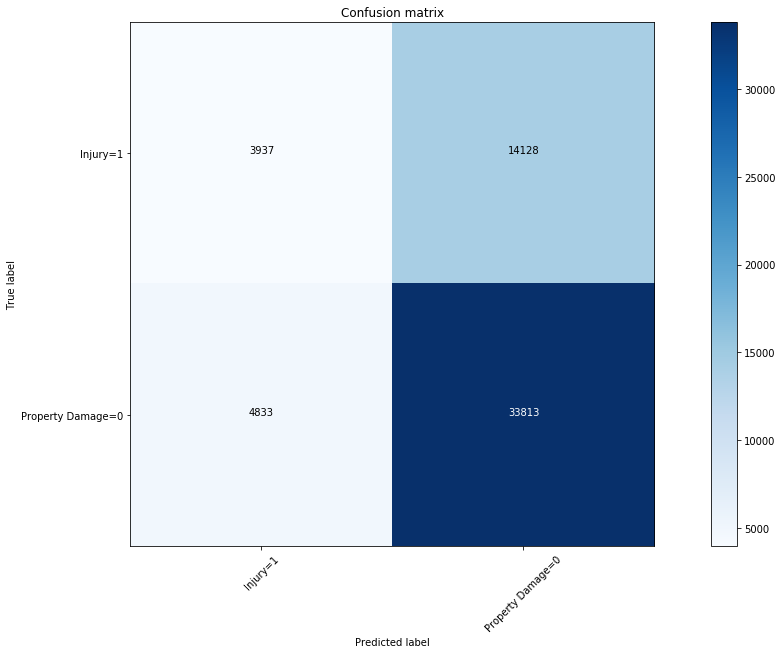

In [22]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

plt.figure()
cm_plot(cnf_matrix, classes=['Injury=1','Property Damage=0'],normalize= False,  title='Confusion matrix')

Accuracy score for Decision Tree =  0.5989753881905566
Confusion Matrix - Decision Tree
Predicted      0      1   2    All
True                              
0          25435  13211   0  38646
1           9568   8497   0  18065
2              0      0  91     91
All        35003  21708  91  56802
              precision    recall  f1-score   support

           0       0.66      0.73      0.69     35003
           1       0.47      0.39      0.43     21708
           2       1.00      1.00      1.00        91

    accuracy                           0.60     56802
   macro avg       0.71      0.71      0.71     56802
weighted avg       0.59      0.60      0.59     56802

Confusion matrix, without normalization
[[ 8497  9568]
 [13211 25435]]


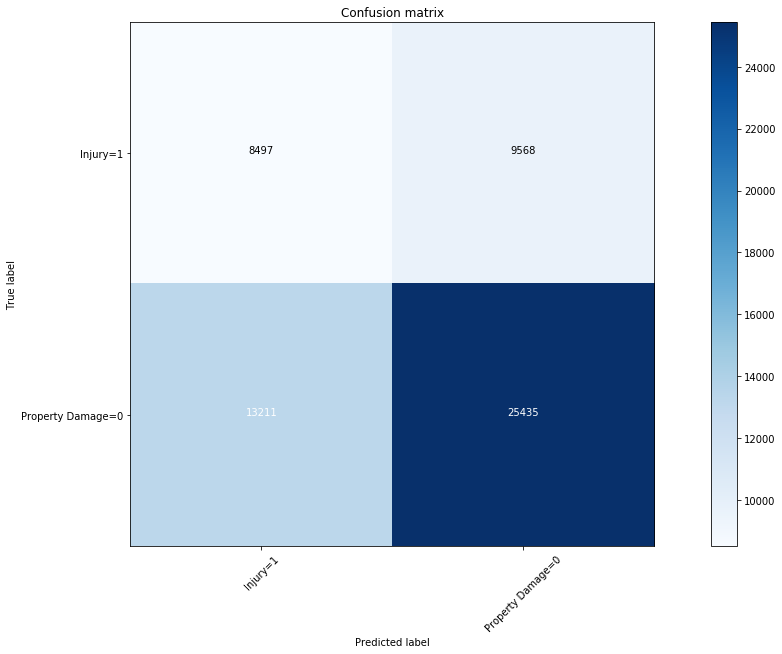

In [17]:
#Decision Tree Clasifier
DT = DecisionTreeClassifier(criterion="entropy", max_depth=6)
DT.fit(smote_data_X, smote_data_y)

        #Make Prediction:
yhatDT = DT.predict(X_test)

        #Check Accuracy
print('Accuracy score for Decision Tree = ', accuracy_score(yhatDT, y_test))

        #Visualization
print('Confusion Matrix - Decision Tree')
print(pd.crosstab(y_test.ravel(), yhatDT.ravel(), rownames = ['True'], colnames = ['Predicted'], margins = True))

print(classification_report(yhatDT,y_test))

cnf_matrix = confusion_matrix(y_test, yhatDT, labels=[1,0])
np.set_printoptions(precision=2)

plt.figure()
cm_plot(cnf_matrix, classes=['Injury=1','Property Damage=0'],normalize= False,  title='Confusion matrix')

0.6906147676313661
Accuracy 0.6031477764867434
              precision    recall  f1-score   support

           0       0.72      0.74      0.73     38646
           1       0.36      0.31      0.33     18065
           2       0.06      1.00      0.12        91

    accuracy                           0.60     56802
   macro avg       0.38      0.68      0.39     56802
weighted avg       0.60      0.60      0.60     56802

Confusion matrix, without normalization
[[ 5549 11168]
 [10025 28620]]


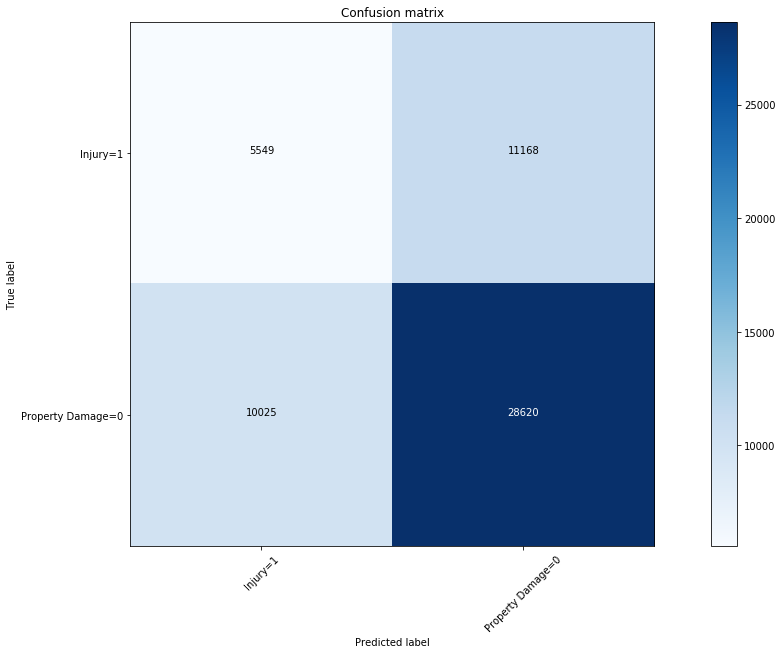

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
#Logistic Regression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(smote_data_X, smote_data_y)

yhatLR = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)

print(log_loss(y_test, yhat_prob))

print ("Accuracy", accuracy_score(yhatLR,y_test))
print (classification_report(y_test, yhatLR))

cnf_matrix = confusion_matrix(y_test, yhatLR, labels=[1,0])
np.set_printoptions(precision=2)


        # Plot confusion matrix
plt.figure()
cm_plot(cnf_matrix, classes=['Injury=1','Property Damage=0'],normalize= False,  title='Confusion matrix')